In [1]:
from __future__ import annotations

import numpy as np
from dataclasses import dataclass
from typing import Tuple, Optional

from scipy.signal import fftconvolve
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

## Create Synthetic Images

In [2]:
def make_synthetic_tfm(h=400, w=500, n_reflectors=25, seed=0):
    rng = np.random.default_rng(seed)

    # Background speckle (band-limited-ish)
    img = rng.normal(0, 1, (h, w)).astype(np.float32)
    img = (img + np.roll(img, 1, 0) + np.roll(img, -1, 0) +
                 np.roll(img, 1, 1) + np.roll(img, -1, 1)) / 5.0

    # Add point reflectors (Gaussian spots)
    yy, xx = np.mgrid[0:h, 0:w]
    for _ in range(n_reflectors):
        y0 = rng.integers(30, h-80)
        x0 = rng.integers(30, w-30)
        amp = rng.uniform(3, 8)
        sy = rng.uniform(2, 6)
        sx = rng.uniform(2, 10)
        img += amp * np.exp(-((yy - y0)**2/(2*sy**2) + (xx - x0)**2/(2*sx**2))).astype(np.float32)

    # Add "back-wall" line near bottom to test masking
    bw = int(h * 0.85)
    img[bw:bw+2, :] += 6.0
    img[bw+2:bw+4, :] += 3.0

    # Normalize to positive-ish (TFM magnitudes are often nonnegative)
    img -= img.min()
    return img

import numpy as np

def split_into_two_with_overlap(base: np.ndarray, overlap_px: int, split_x: int | None = None):
    """
    Split base into two images with overlap.
    - overlap_px: number of columns shared by both images
    - split_x: split location (column index where frame0 ends before overlap). If None, split in the middle.
    Returns: frame0, frame1
    """
    H, W = base.shape
    if split_x is None:
        split_x = W // 2

    if overlap_px <= 0 or overlap_px >= W:
        raise ValueError("overlap_px must be in (0, W).")
    if split_x <= overlap_px or split_x >= W - 1:
        raise ValueError("split_x must be > overlap_px and < W.")

    frame0 = base[:, :split_x].copy()
    frame1 = base[:, split_x - overlap_px:].copy()
    return frame0, frame1


def shift_image_x(img, dx):
    """Integer shift in x; pad with zeros."""
    h, w = img.shape
    out = np.zeros_like(img)
    if dx >= 0:
        out[:, dx:] = img[:, :w-dx]
    else:
        out[:, :w+dx] = img[:, -dx:]
    return out

def make_frames_from_base(base, dx_list, noise_sigma=0.2, gain_jitter=0.05, seed=1):
    rng = np.random.default_rng(seed)
    frames = []
    for dx in dx_list:
        f = shift_image_x(base, dx)
        # mild gain drift + noise
        f = f * (1.0 + rng.normal(0, gain_jitter))
        f = f + rng.normal(0, noise_sigma, f.shape).astype(np.float32)
        f[f < 0] = 0
        frames.append(f.astype(np.float32))
    return frames


def show_img(img, title="", cmap="gray", vmin=None, vmax=None):
    plt.figure()
    plt.imshow(img, cmap=cmap, aspect="auto", vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def show_pair(img1, img2, title1="Image 1", title2="Image 2", cmap="gray"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(img1, cmap=cmap, aspect="auto")
    ax[0].set_title(title1); ax[0].axis("off")
    ax[1].imshow(img2, cmap=cmap, aspect="auto")
    ax[1].set_title(title2); ax[1].axis("off")
    fig.tight_layout()
    plt.show()

def show_overlap_preview(img1, img2, dx, alpha=0.5, cmap="gray"):
    """
    Visualize how img2 lands relative to img1 with shift dx (pixels).
    Shows a canvas where both are placed; overlap appears brighter.
    """
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    assert h1 == h2

    x1_start, x2_start = 0, dx
    x_min = min(x1_start, x2_start)
    x_max = max(x1_start + w1, x2_start + w2)
    W = x_max - x_min
    H = h1

    x1 = x1_start - x_min
    x2 = x2_start - x_min

    canvas1 = np.zeros((H, W), dtype=np.float32)
    canvas2 = np.zeros((H, W), dtype=np.float32)
    canvas1[:, x1:x1+w1] = img1.astype(np.float32)
    canvas2[:, x2:x2+w2] = img2.astype(np.float32)

    # Normalize for display
    def norm(x):
        x = x - x.min()
        return x / (x.max() + 1e-9)

    overlay = (1 - alpha) * norm(canvas1) + alpha * norm(canvas2)

    plt.figure(figsize=(10, 4))
    plt.imshow(overlay, cmap=cmap, aspect="auto")
    plt.title(f"Overlay preview (dx={dx}px)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

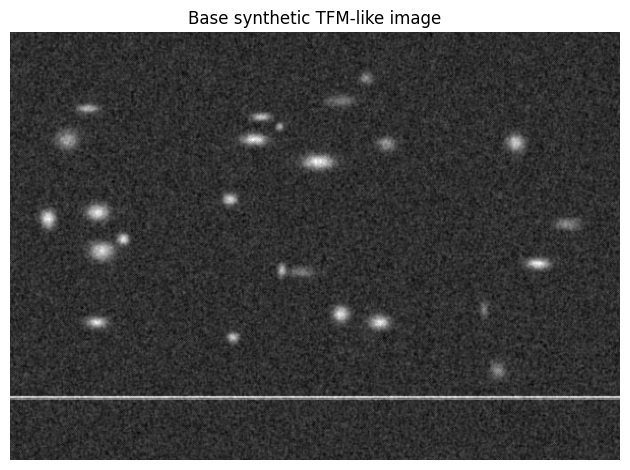

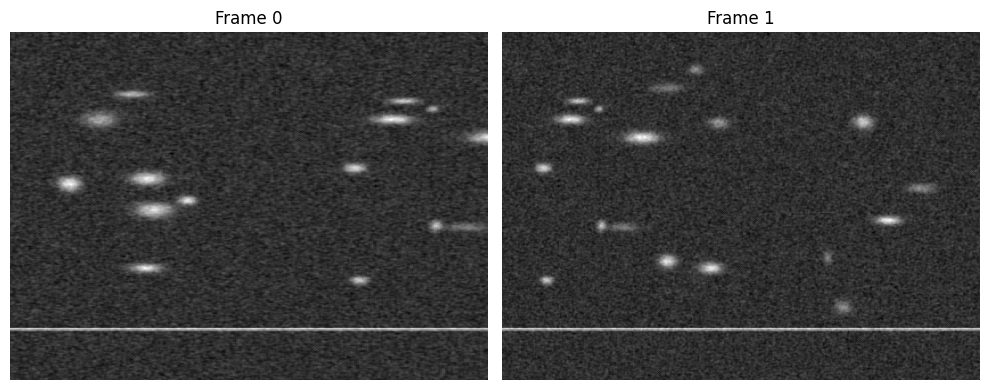

In [17]:
base = make_synthetic_tfm(h=400, w=600, seed=1)
frames = split_into_two_with_overlap(base, overlap_px=120)

show_img(base, "Base synthetic TFM-like image")
show_pair(frames[0], frames[1], "Frame 0", "Frame 1")

## Stitch 

In [18]:
def show(img, title="", cmap="gray"):
    plt.figure(figsize=(7, 4))
    plt.imshow(img, cmap=cmap, aspect="auto")
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def show2(a, b, title1="A", title2="B", cmap="gray"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].imshow(a, cmap=cmap, aspect="auto"); ax[0].set_title(title1); ax[0].axis("off")
    ax[1].imshow(b, cmap=cmap, aspect="auto"); ax[1].set_title(title2); ax[1].axis("off")
    fig.tight_layout()
    plt.show()


# ----------------------------
# Core steps (paper-matching)
# ----------------------------
def normalize_for_corr(img: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    x = img.astype(np.float32)
    x = x - x.mean()
    return x / (x.std() + eps)

def to_uint8(img: np.ndarray) -> np.ndarray:
    x = img.astype(np.float32)
    x = x - x.min()
    mx = x.max()
    if mx > 0:
        x = x / mx
    return (255.0 * x).clip(0, 255).astype(np.uint8)

def mask_backwall_for_registration(tfm_img: np.ndarray, extra_margin_px: int = 2):
    """
    Paper step 3.3.2:
    - threshold below mean -> 0
    - gradient per column; take max positive gradient index as backwall candidate
    - robust aggregate (median), erase below backwall
    Returns: masked_img, backwall_row (or None)
    """
    img = tfm_img.astype(np.float32).copy()

    # threshold below mean
    mean_val = img.mean()
    img[img < mean_val] = 0.0

    # gradient along depth (rows)
    g = np.diff(img, axis=0)

    bw_idx = []
    for j in range(g.shape[1]):
        col = g[:, j]
        if np.all(col == 0):
            continue
        bw_idx.append(int(np.argmax(col)))

    if not bw_idx:
        return img, None

    backwall_row = int(np.median(bw_idx)) + extra_margin_px
    masked = img.copy()
    masked[backwall_row:, :] = 0.0
    return masked, backwall_row


def corr_curve_shift_x(img1_mask: np.ndarray, img2_mask: np.ndarray, dx_min: int, dx_max: int):
    """
    Paper step 3.3.3:
    overlap img2 on img1 from left->right; compute correlation for each dx.
    Uses dot-product on normalized overlapping regions; then normalized to [0,1].
    Returns: dxs, corr_norm
    """
    a = normalize_for_corr(img1_mask)
    b = normalize_for_corr(img2_mask)

    h, w1 = a.shape
    _, w2 = b.shape

    dxs = np.arange(dx_min, dx_max + 1)
    scores = np.full_like(dxs, fill_value=-np.inf, dtype=np.float32)

    for t, dx in enumerate(dxs):
        ov_start = max(0, dx)
        ov_end = min(w1, dx + w2)
        if ov_end <= ov_start:
            continue
        a_ov = a[:, ov_start:ov_end]
        b_ov = b[:, (ov_start - dx):(ov_end - dx)]
        scores[t] = float(np.sum(a_ov * b_ov))

    # normalize 0..1 (as described in the paper)
    finite = np.isfinite(scores)
    s = scores[finite]
    if s.size == 0:
        corr01 = scores
    else:
        mn, mx = float(s.min()), float(s.max())
        corr01 = (scores - mn) / (mx - mn + 1e-12)

    return dxs, corr01


def stitch_canvas(img1: np.ndarray, img2: np.ndarray, dx: int):
    """
    Place img1 at x=0, img2 at x=dx on a canvas spanning both (width grows).
    Returns: canvas1, canvas2, x1, x2
    """
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    if h1 != h2:
        raise ValueError("Heights must match.")

    x_min = min(0, dx)
    x_max = max(w1, dx + w2)
    W = x_max - x_min
    H = h1

    x1 = -x_min
    x2 = dx - x_min

    c1 = np.zeros((H, W), dtype=np.float32)
    c2 = np.zeros((H, W), dtype=np.float32)
    c1[:, x1:x1+w1] = img1.astype(np.float32)
    c2[:, x2:x2+w2] = img2.astype(np.float32)
    return c1, c2, x1, x2


def combine_no_seam_removal(c1: np.ndarray, c2: np.ndarray):
    """
    "Seam not removed": simple average where both exist.
    """
    w1 = (c1 != 0).astype(np.float32)
    w2 = (c2 != 0).astype(np.float32)
    w = w1 + w2
    out = np.where(w > 0, (c1 + c2) / np.maximum(w, 1e-9), 0.0)
    return out


def combine_weighted_blend(img1: np.ndarray, img2: np.ndarray, dx: int):
    """
    Paper Eq.(5): linear weights across overlap.
    Returns: blended_out, x1, x2
    """
    c1, c2, x1, x2 = stitch_canvas(img1, img2, dx)

    # compute overlap bounds in canvas
    w1 = img1.shape[1]
    w2 = img2.shape[1]
    ov_start = max(x1, x2)
    ov_end = min(x1 + w1, x2 + w2)
    overlap = max(0, ov_end - ov_start)

    out = np.zeros_like(c1, dtype=np.float32)

    # start with img1 region
    out[:] = c1

    if overlap == 0:
        # paste img2 where it exists
        mask2 = (c2 != 0)
        out[mask2] = c2[mask2]
        return out, x1, x2

    # paste img2 non-overlap parts
    mask2 = (c2 != 0)
    out[mask2] = c2[mask2]  # temporary; will overwrite overlap with blend

    # build linear ramps across overlap
    w2_ramp = np.linspace(0.0, 1.0, overlap, endpoint=False, dtype=np.float32)[None, :]
    w1_ramp = 1.0 - w2_ramp

    # fetch overlap strips from original images
    img1_ov = img1.astype(np.float32)[:, (ov_start - x1):(ov_end - x1)]
    img2_ov = img2.astype(np.float32)[:, (ov_start - x2):(ov_end - x2)]

    out[:, ov_start:ov_end] = w1_ramp * img1_ov + w2_ramp * img2_ov
    return out, x1, x2


def debug_stitch_step(img1: np.ndarray, img2: np.ndarray, use_backwall_mask=True, search_margin_px=None):
    """
    Runs one stitching iteration and VISUALIZES all intermediate outputs like the paper.
    """
    # Step A: show inputs
    show2(img1, img2, "Input Image 1", "Input Image 2")

    # Step B: masking for registration (copies only)
    if use_backwall_mask:
        m1, bw1 = mask_backwall_for_registration(img1)
        m2, bw2 = mask_backwall_for_registration(img2)

        show(m1, f"Mask for registration (Img1)  backwall_row={bw1}")
        show(m2, f"Mask for registration (Img2)  backwall_row={bw2}")
    else:
        m1, m2 = img1, img2

    # Step C: correlation curve left->right and dx selection
    w1 = m1.shape[1]
    w2 = m2.shape[1]
    dx_min = -w2 + 1
    dx_max = w1 - 1

    if search_margin_px is not None:
        dx_min = max(dx_min, -search_margin_px)
        dx_max = min(dx_max,  search_margin_px)

    dxs, corr01 = corr_curve_shift_x(m1, m2, dx_min, dx_max)
    best_dx = int(dxs[np.nanargmax(corr01)])

    plt.figure(figsize=(8, 4))
    plt.plot(dxs, corr01)
    plt.axvline(best_dx, linestyle="--")
    plt.title(f"Correlation vs dx (normalized 0–1), best dx = {best_dx}")
    plt.xlabel("dx (pixels)")
    plt.ylabel("Normalized correlation")
    plt.tight_layout()
    plt.show()

    # Step D: show placement canvas (like Fig 8c)
    c1, c2, x1, x2 = stitch_canvas(img1, img2, best_dx)
    # visualize placement by overlay (not blended yet)
    overlay = (c1 - c1.min()) / (c1.max() - c1.min() + 1e-9) * 0.5 + (c2 - c2.min()) / (c2.max() - c2.min() + 1e-9) * 0.5
    show(overlay, f"Image shift placement overlay (dx={best_dx})", cmap="gray")

    # Step E: seam not removed (simple average)
    no_seam = combine_no_seam_removal(c1, c2)
    show(no_seam, "Combined (seam not removed) – simple average")

    # Step F: seam removed (weighted blend Eq.(5))
    seam_removed, x1b, x2b = combine_weighted_blend(img1, img2, best_dx)
    show(seam_removed, "Combined (seam removed) – weighted blend")

    # Step G: IQA (PSNR/SSIM) against both originals, using embedded patches
    u_out = to_uint8(seam_removed)
    u1 = to_uint8(img1)
    u2 = to_uint8(img2)

    patch1 = u_out[:, x1b:x1b + img1.shape[1]]
    patch2 = u_out[:, x2b:x2b + img2.shape[1]]

    psnr1 = peak_signal_noise_ratio(u1, patch1, data_range=255)
    ssim1 = structural_similarity(u1, patch1, data_range=255)
    psnr2 = peak_signal_noise_ratio(u2, patch2, data_range=255)
    ssim2 = structural_similarity(u2, patch2, data_range=255)

    print(f"dx={best_dx}")
    print(f"PSNR vs Img1: {psnr1:.3f} dB, SSIM vs Img1: {ssim1:.4f}")
    print(f"PSNR vs Img2: {psnr2:.3f} dB, SSIM vs Img2: {ssim2:.4f}")

    return seam_removed.astype(img1.dtype), best_dx


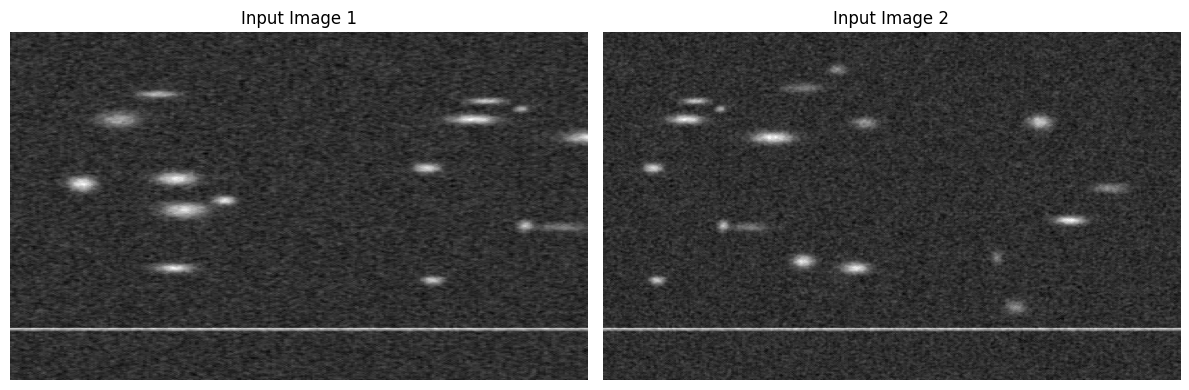

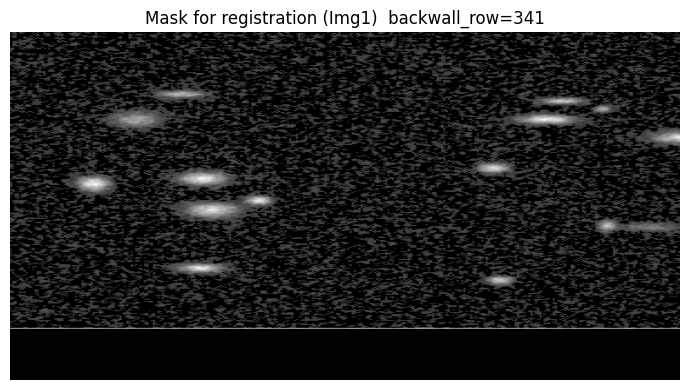

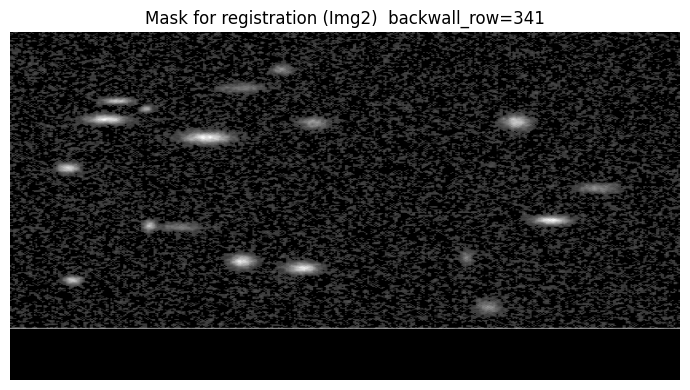

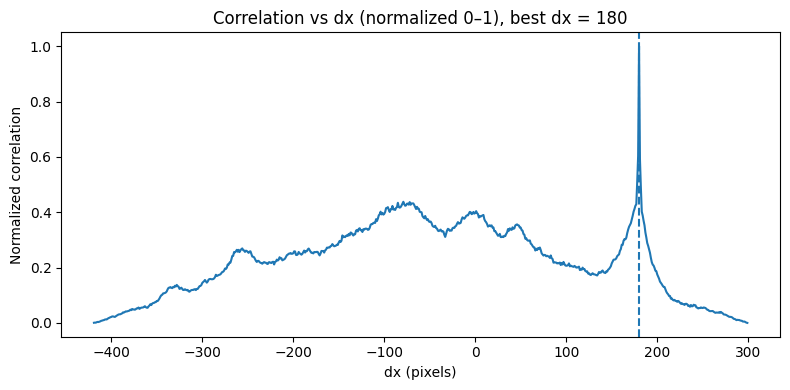

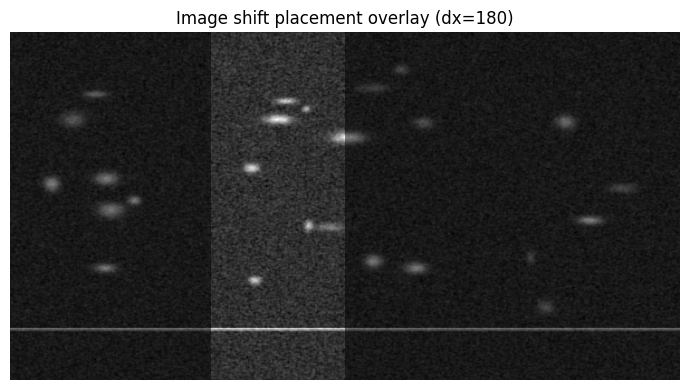

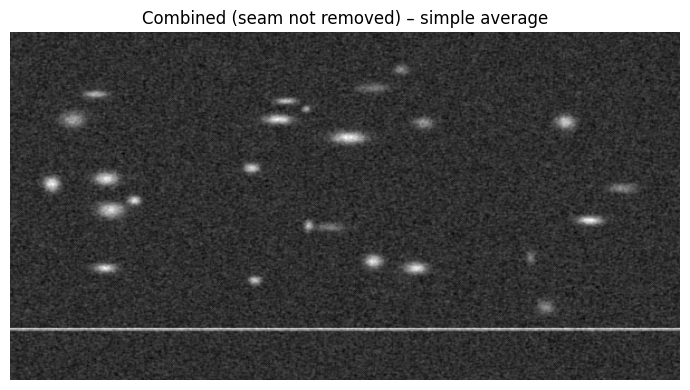

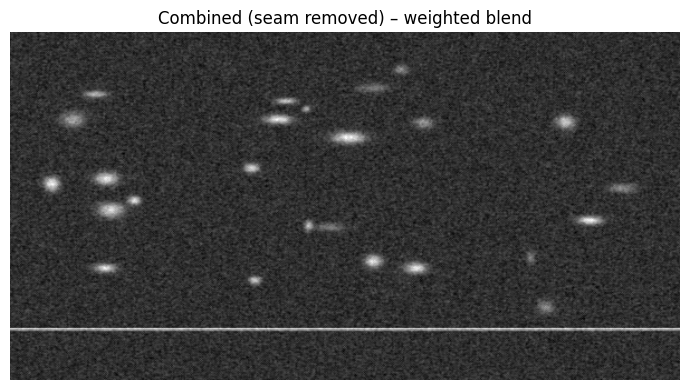

dx=180
PSNR vs Img1: 50.685 dB, SSIM vs Img1: 0.9991
PSNR vs Img2: inf dB, SSIM vs Img2: 1.0000


/Users/theotabet/Documents/[4] UNIVERSITY/Y4/[5] GROUP INDUSTRIAL PROJECT/[2] CODE/signal-processing-G2066/.venv/lib/python3.13/site-packages/skimage/metrics/simple_metrics.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [19]:
stitched01, dx01 = debug_stitch_step(frames[0], frames[1], use_backwall_mask=True, search_margin_px=800)


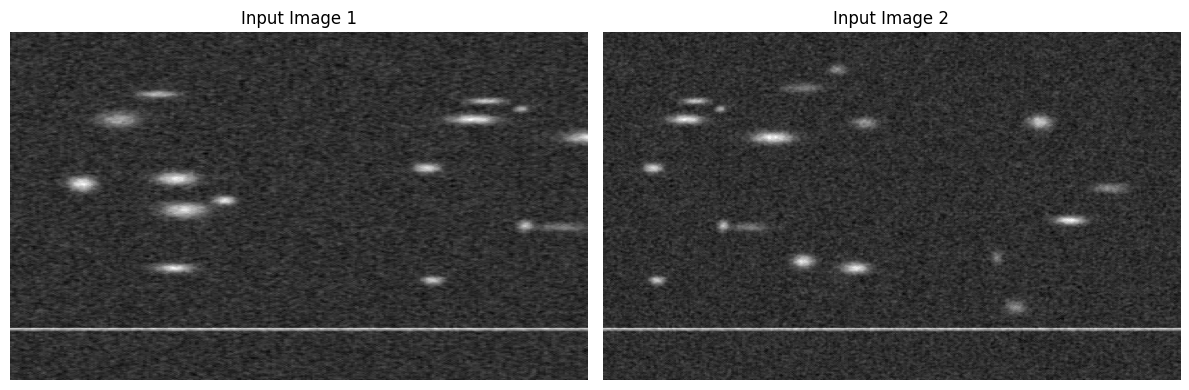

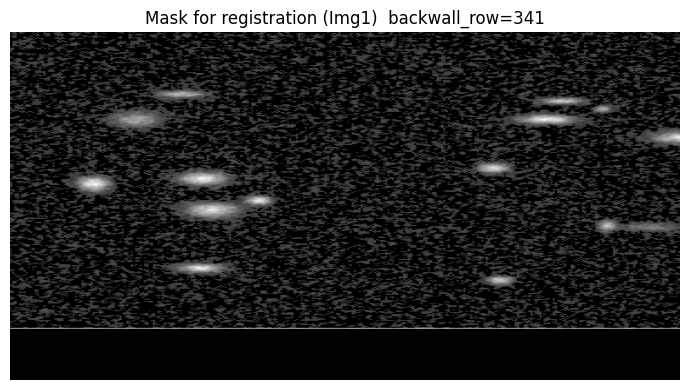

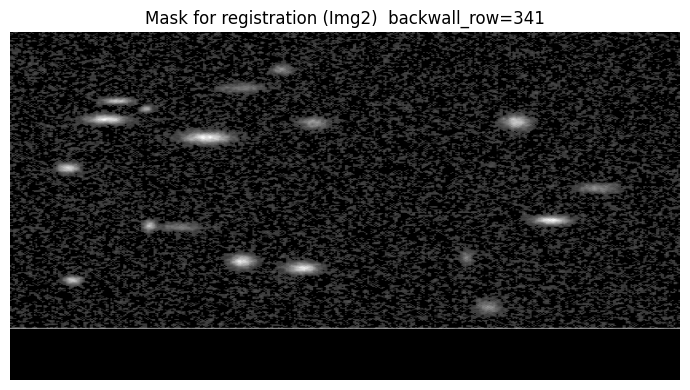

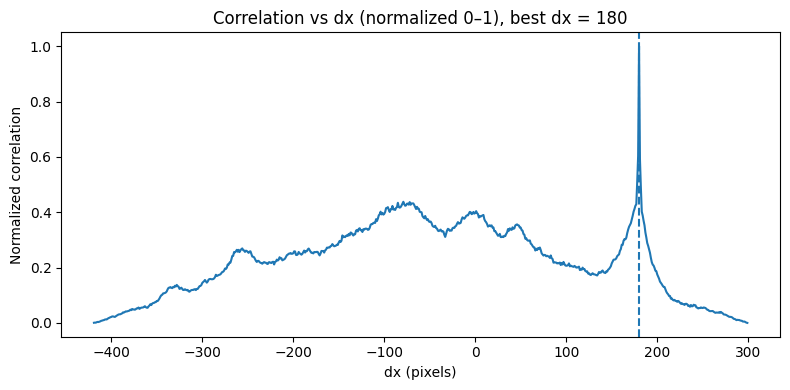

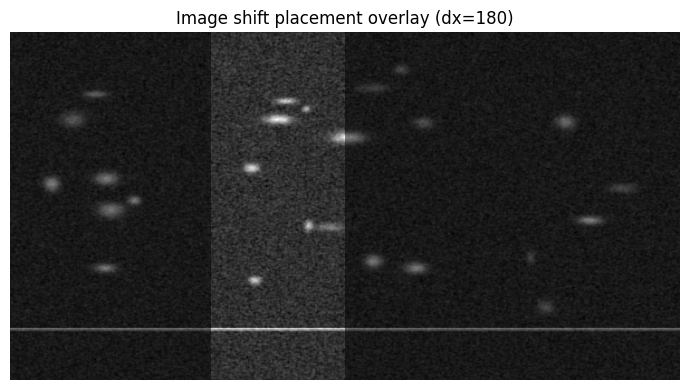

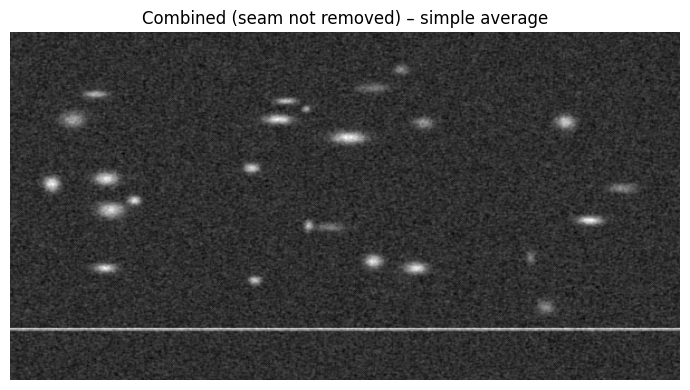

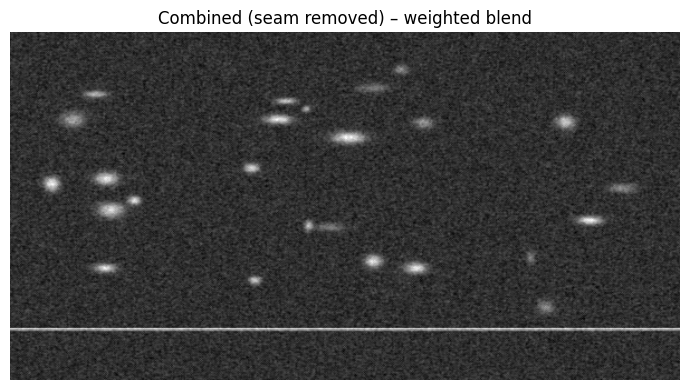

dx=180
PSNR vs Img1: 50.685 dB, SSIM vs Img1: 0.9991
PSNR vs Img2: inf dB, SSIM vs Img2: 1.0000
dx per step: [180]


In [20]:
stitched = frames[0]
dxs = []

for k in range(1, len(frames)):
    stitched, dx = debug_stitch_step(stitched, frames[k], use_backwall_mask=True, search_margin_px=800)
    dxs.append(dx)

print("dx per step:", dxs)
